In [677]:
import base64
import json
import requests
import numpy as np
import time, sys

from datetime import date
from IPython.display import clear_output
from matplotlib import pyplot
from matplotlib.dates import WEEKLY, DateFormatter

import matplotlib.dates as mdates

In [505]:
with open('config.json', 'r') as config:
    data = json.loads(config.read())
    SPOTIFY_CLIENT_ID = data['spotify_client_id']
    SPOTIFY_CLIENT_SECRET = data['spotify_client_secret']

SPOTIFY_AUTH_URL = "https://accounts.spotify.com/api/token"

def get_api_token():
    auth_string = f'{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}'.encode('utf-8')
    auth_encoded = base64.b64encode(auth_string).decode('utf-8')
    response = requests.post(SPOTIFY_AUTH_URL, data={
      'grant_type': 'client_credentials'  
    }, headers = {
        'Authorization': 'Basic {}'.format(auth_encoded)
    })
    return response.json()['access_token']

In [343]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [633]:
base_url = "https://playlist.cprnetwork.org/api/playlistCO/selectDate:{}"
# Dates are sent to the API in the following format yyyy-mm-dd (%Y-%m-%d) base64 encoded
june_dates = [date(2019, 6, i) for i in range(1, 31)]
july_dates = [date(2019, 7, i) for i in range(1, 32)]


def fetch_tracks(dates):
    tracks = []
    total = len(dates)
    for num, d in enumerate(dates):
        formatted = d.strftime('%Y-%m-%d').encode('utf-8')
        encoded = base64.b64encode(formatted).decode('utf-8')
        url = base_url.format(str(encoded))
        response = requests.get(url)
        tracks.append(response.json())
        update_progress(num / (total -1))
    return tracks


In [636]:
june_raw_tracks = fetch_tracks(june_dates)
july_raw_tracks = fetch_tracks(july_dates)

Progress: [####################] 100.0%


In [387]:
def save_json(name, tracklist):
    # dont want to wait for the api again just save it
    with open(name, 'w') as f:
        f.write(json.dumps(tracklist))

def load_json(name):
    with open(name, 'r') as f:
        data = f.read()
        return json.loads(data)

In [396]:
spotify_url = "https://api.spotify.com/v1/search?"
def spotify_search(track, token):
    # q=album%3AHeartworms%20artist%3AThe%20Shins%20track%3A%20Name%20For%20You&type=track
    search_string = f"type=track&q=artist:{track['artist']} track:{track['title']}"
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer {}".format(token)
    }
    response = requests.get(spotify_url + search_string, headers=headers)
    return response.json()


In [709]:
def append_spotify_popularity(days): 
    errors = []
    token = get_api_token()
    total = sum(len(day) for day in days)
    count = 0
    for tracks in days:
        for track in tracks:
            count += 1
            result = spotify_search(track, token)
            try:
                track['popularity'] = result['tracks']['items'][0]['popularity']
            except (IndexError, KeyError) as e:
                errors.append({'track': track, 'error': e})
            update_progress(count / (total - 1))
    return days, errors

In [645]:
june_tracks, errors = append_spotify_popularity(june_tracks)

In [642]:
july_tracks, errors = append_spotify_popularity(july_tracks)

In [625]:
def get_daily_averages(month):
    avgs = []
    for day in month:
        popularity_list = [track['popularity'] for track in day if track.get('popularity', None) is not None]
        avgs.append(sum(popularity_list) / len(popularity_list))
    return avgs
july_avgs = get_daily_averages(july_tracks)
june_avgs = get_daily_averages(june_tracks)

In [715]:
def draw_histogram(june, july):
    p1 = []
    p2 = []
    for day in june:
        for track in day:
            p = track.get('popularity', False)
            if p:
                p1.append(p)
    for day in july:
        for track in day:
            p = track.get('popularity', False)
            if p:
                p2.append(p)
    pyplot.hist([p1,p2], bins=20, label=["June", "July"])
    pyplot.ylabel('Track Count')
    pyplot.xlabel('Popularity')
    pyplot.legend(prop={'size': 10})
    pyplot.show()

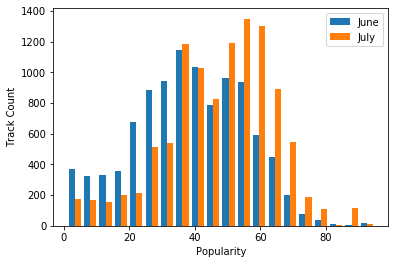

In [716]:
draw_histogram(june_tracks, july_tracks)

In [647]:
save_json('june.json', june_tracks)
save_json('july.json', july_tracks)

In [643]:
def get_medians(days):
    medians = []
    for tracks in days:
        arr = []
        for t in tracks:
            if t.get('popularity', None):
                arr.append(t['popularity'])
        medians.append(np.median(arr))
    return medians
        
june_medians = get_medians(june_tracks)
july_medians = get_medians(july_tracks)
        

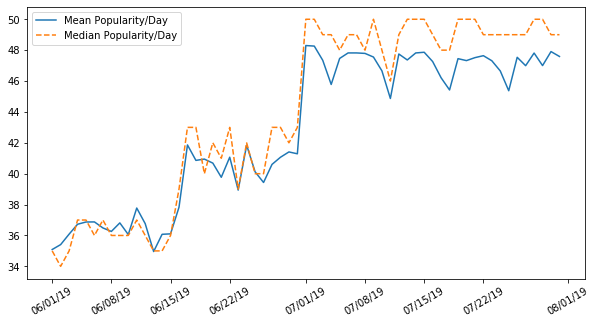

In [708]:
fig, ax = pyplot.subplots()
fig.set_figwidth(10)
fig.set_figheight(5)
formatter = DateFormatter('%m/%d/%y')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
pyplot.plot_date(june_dates + july_dates, june_avgs + july_avgs, xdate=True, fmt="-", label="Mean Popularity/Day")
pyplot.plot_date(june_dates + july_dates, june_medians + july_medians, xdate=True, fmt="--", label="Median Popularity/Day")
pyplot.legend(prop={'size': 10})
pyplot.show()